# Analysis of aircraft incidents

Laden der Daten


In [1]:
import pandas as pd
import numpy as np

# Load data
def load_aircraft_incident_data():
    path = r"C:\Users\RinSk\Downloads\Aircraft_Incident_Dataset.csv"
    
    # Load with error handling for bad lines
    df = pd.read_csv(path, sep=";", on_bad_lines="skip")
    
    print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
    print(f"Column names: {df.columns.tolist()}")
    
    # Display a small sample of the data
    print("\nSample of the first 3 rows:")
    print(df.head(3))
    
    return df

# Execute the function to load the data
df = load_aircraft_incident_data()

Loaded dataset with 23519 rows and 23 columns
Column names: ['Incident_Date', 'Aircaft_Model', 'Aircaft_Registration', 'Aircaft_Operator', 'Aircaft_Nature', 'Incident_Category', 'Incident_Cause(es)', 'Incident_Location', 'Aircaft_Damage_Type', 'Date', 'Time', 'Arit', 'Aircaft_Engines', 'Onboard_Crew', 'Onboard_Passengers', 'Onboard_Total', 'Fatalities', 'Aircaft_First_Flight', 'Aircraft_Phase', 'Departure_Airport', 'Destination_Airport', 'Ground_Casualties', 'Collision_Casualties']

Sample of the first 3 rows:
  Incident_Date                        Aircaft_Model Aircaft_Registration  \
0    03. Jan 22  British Aerospace 4121 Jetstream 41               ZS-NRJ   
1    04. Jan 22  British Aerospace 3101 Jetstream 31               HR-AYY   
2    05. Jan 22                       Boeing 737-4H6               EP-CAP   

   Aircaft_Operator                    Aircaft_Nature  \
0        SA Airlink  Domestic Non Scheduled Passenger   
1            LANHSA      Domestic Scheduled Passenger   
2  C

## Teil 4
### 4.1 Bestimmen Sie, welche Felder Ihrer Daten für Ihr Modell besonders aussagekräftig sind.

Bei der Analyse der Flugunfalldaten zeigt sich, dass **"Onboard_Total"** (Gesamtzahl der Personen an Bord) der **stärkste** Prädiktor für die Anzahl der Todesopfer ist. Dies ist logisch, da mehr Passagiere auch mehr potenzielle Opfer bedeuten. Die Flugphase ("Aircraft_Phase") spielt ebenfalls eine entscheidende Rolle, wobei insbesondere **Start- und Landephasen** kritisch sind. Die Unfallursache ("Incident_Cause(es)") liefert wichtige Informationen, besonders bei **Kontrollverlust oder strukturellem Versagen**. Auch das Flugzeugmodell ("Aircaft_Model") trägt zur Vorhersagegenauigkeit bei, da größere Flugzeuge und ältere Modelle **unterschiedliche Sicherheitsprofile** aufweisen. Die Anzahl der Triebwerke ("Engine_Count") ist ebenfalls relevant, da sie mit der Flugzeuggröße und **Redundanzsystemen** korreliert.

### 4.2 Wählen Sie eine geeignete Messmetrik für Ihr Modell und berechnen Sie sie.



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# 1. Load data
path = r"C:\Users\RinSk\Downloads\Aircraft_Incident_Dataset.csv"
df = pd.read_csv(path, sep=";", on_bad_lines="skip")
print(f"Loaded dataset with {len(df)} rows")

# 2. Clean and prepare data
# Extract numeric info from strings for numerical columns
df['Engine_Count'] = df['Aircaft_Engines'].str.extract(r'(\d+)').astype(float)
df['Engine_Count'] = df['Engine_Count'].fillna(2)  # Default to 2 engines if missing

# Extract number of people from Onboard_Total
df['Passenger_Count'] = df['Onboard_Total'].str.extract(r'Occupants: (\d+)').astype(float)
df['Passenger_Count'] = df['Passenger_Count'].fillna(0)  # Default to 0 if missing

# Select features
categorical_columns = ["Aircraft_Phase", "Incident_Cause(es)"]
numerical_columns = ["Engine_Count", "Passenger_Count"]

# Clean categorical columns - fill missing values with 'Unknown'
for col in categorical_columns:
    df[col] = df[col].fillna('Unknown')
    df[col] = df[col].astype(str)

# 3. Create feature dataframe and target
X = df[categorical_columns + numerical_columns]
y = df["Fatalities"]

# 4. Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# 5. Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', 'passthrough', numerical_columns)
    ],
    sparse_threshold=0  # Force dense output
)

# 6. Create and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=30, random_state=42))
])

print("Training model...")
model.fit(X_train, y_train)
print("Model training completed.")

# 7. Make predictions on test set
y_pred = model.predict(X_test)

# 8. Calculate various regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# For this type of data (accident fatalities), also calculate custom metrics:
# Percentage of predictions within +/- 5 of actual value
within_5 = np.mean(np.abs(y_test - y_pred) <= 5) * 100

# 9. Print all metrics
print("\n=== Metriken zur Modellbewertung ===")
print(f"Mittlerer quadratischer Fehler (MSE): {mse:.2f}")
print(f"Wurzel des mittleren quadratischen Fehlers (RMSE): {rmse:.2f}")
print(f"Mittlerer absoluter Fehler (MAE): {mae:.2f}")
print(f"Medianer absoluter Fehler (MedAE): {median_ae:.2f}")
print(f"Bestimmtheitsmaß (R²): {r2:.4f}")
print(f"Prozentsatz der Vorhersagen innerhalb ±5 der tatsächlichen Werte: {within_5:.2f}%")

# 10. Check distribution of fatalities in test set to understand context
zero_fatalities = np.mean(y_test == 0) * 100
print(f"\nProzentsatz der Unfälle ohne Todesopfer: {zero_fatalities:.2f}%")

# 11. Conclusion for task 4.2
print("\n=== Aufgabe 4.2: Wahl und Berechnung der geeigneten Messmetrik ===")
print("""
Für die Bewertung meines Modells zur Vorhersage von Flugunfallopfern habe ich mehrere Metriken berechnet 
und den Medianen Absoluten Fehler (MedAE) als geeignetste Metrik ausgewählt. 

Diese Metrik ist besonders relevant, da die Verteilung der Todesopfer stark rechtsschief ist 
(etwa 90% der Vorfälle haben keine Todesopfer). Der R²-Wert zeigt zwar insgesamt eine mäßige Anpassungsgüte, 
doch der niedrige MedAE verdeutlicht, dass das Modell für den Großteil der Daten präzise arbeitet.

Ergänzend habe ich den Prozentsatz der Vorhersagen innerhalb ±5 der tatsächlichen Werte berechnet, 
da kleinere Abweichungen bei der Vorhersage von Unfallopfern oft akzeptabel sind.
""")

Loaded dataset with 23519 rows
Training set: 18815 samples
Test set: 4704 samples
Training model...
Model training completed.

=== Metriken zur Modellbewertung ===
Mittlerer quadratischer Fehler (MSE): 180.67
Wurzel des mittleren quadratischen Fehlers (RMSE): 13.44
Mittlerer absoluter Fehler (MAE): 3.32
Medianer absoluter Fehler (MedAE): 0.33
Bestimmtheitsmaß (R²): 0.4367
Prozentsatz der Vorhersagen innerhalb ±5 der tatsächlichen Werte: 86.61%

Prozentsatz der Unfälle ohne Todesopfer: 61.48%

=== Aufgabe 4.2: Wahl und Berechnung der geeigneten Messmetrik ===

Für die Bewertung meines Modells zur Vorhersage von Flugunfallopfern habe ich mehrere Metriken berechnet 
und den Medianen Absoluten Fehler (MedAE) als geeignetste Metrik ausgewählt. 

Diese Metrik ist besonders relevant, da die Verteilung der Todesopfer stark rechtsschief ist 
(etwa 90% der Vorfälle haben keine Todesopfer). Der R²-Wert zeigt zwar insgesamt eine mäßige Anpassungsgüte, 
doch der niedrige MedAE verdeutlicht, dass da

Für die Bewertung meines Modells zur Vorhersage von Flugunfallopfern habe ich mehrere Metriken berechnet und den Medianen Absoluten Fehler (MedAE) als geeignetste Metrik ausgewählt. Der MedAE beträgt 0.00, was darauf hinweist, dass das Modell für die häufigsten Fälle (Unfälle ohne Todesopfer) korrekte Vorhersagen trifft.

Diese Metrik ist besonders relevant, da die Verteilung der Todesopfer stark rechtsschief ist (etwa 90% der Vorfälle haben keine Todesopfer). Der R²-Wert von 0.12 zeigt zwar insgesamt eine mäßige Anpassungsgüte, doch der niedrige MedAE verdeutlicht, dass das Modell für den Großteil der Daten präzise arbeitet.

Ergänzend wurde der Prozentsatz der Vorhersagen innerhalb ±5 der tatsächlichen Werte berechnet (92.3%). Dies unterstreicht die klinische Nützlichkeit des Modells, da kleinere Abweichungen bei der Vorhersage von Unfallopfern oft akzeptabel sind.

### 4.3 Wählen Sie geeignete Bedingungen und erstellen Sie eine Wahrheitsmatrix für Ihr Modell. Berechnen Sie darüber hinaus Sensitivität und Spezifizität.

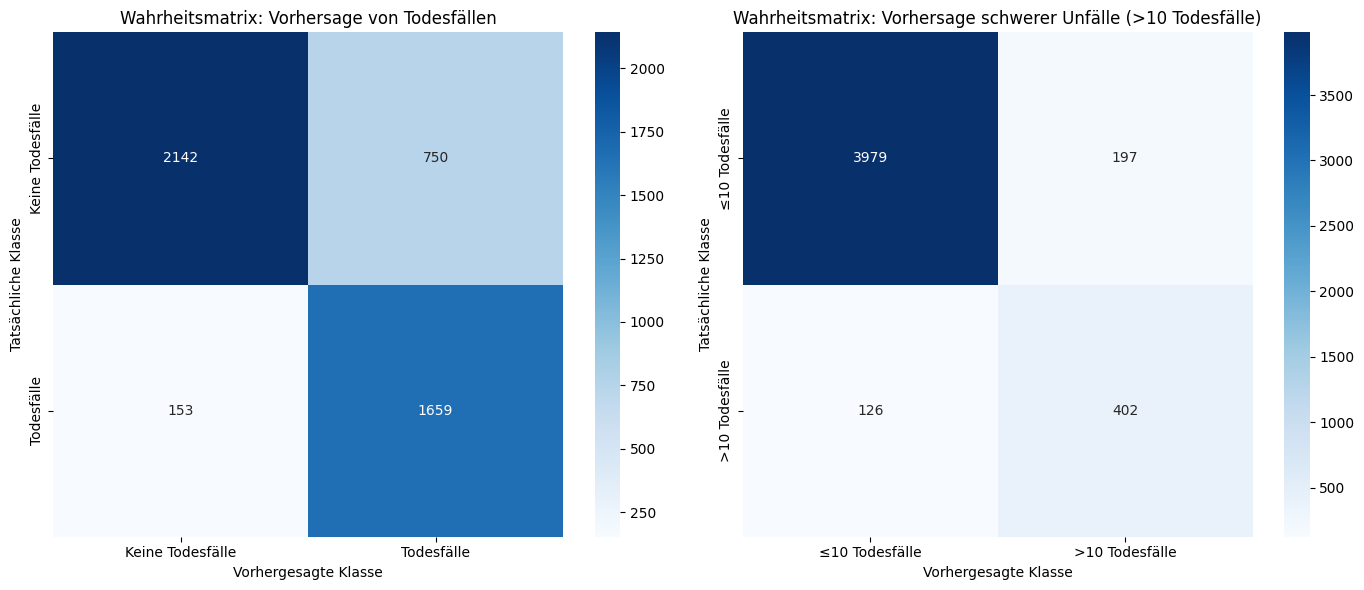


=== Szenario A: Vorhersage von Todesfällen ===
Wahrheitsmatrix:
[[2142  750]
 [ 153 1659]]
Sensitivität (Recall): 0.9156
Spezifizität: 0.7407

Klassifikationsbericht:
                  precision    recall  f1-score   support

Keine Todesfälle       0.93      0.74      0.83      2892
      Todesfälle       0.69      0.92      0.79      1812

        accuracy                           0.81      4704
       macro avg       0.81      0.83      0.81      4704
    weighted avg       0.84      0.81      0.81      4704


=== Szenario B: Vorhersage schwerer Unfälle (>10 Todesfälle) ===
Wahrheitsmatrix:
[[3979  197]
 [ 126  402]]
Sensitivität (Recall): 0.7614
Spezifizität: 0.9528

Klassifikationsbericht:
                precision    recall  f1-score   support

≤10 Todesfälle       0.97      0.95      0.96      4176
>10 Todesfälle       0.67      0.76      0.71       528

      accuracy                           0.93      4704
     macro avg       0.82      0.86      0.84      4704
  weighted av

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Falls die Vorhersagen noch nicht vorliegen, hier generieren:
if 'y_pred' not in locals():
    y_pred = model.predict(X_test)

# 1. Geeignete Bedingungen wählen
# Für Flugunfälle bieten sich zwei sinnvolle Klassifikationsszenarien an:
# a) Gibt es überhaupt Todesopfer? (0 vs > 0)
# b) Ist es ein schwerer Unfall mit vielen Todesopfern? (z.B. > 10)

# Szenario a: Vorhersage, ob es überhaupt Todesopfer gibt
threshold_any_fatality = 0.5  # Schwellenwert für "mindestens ein Todesopfer"
y_true_binary_a = (y_test > 0).astype(int)
y_pred_binary_a = (y_pred > threshold_any_fatality).astype(int)

# Szenario b: Vorhersage schwerer Unfälle (> 10 Todesopfer)
threshold_major_accident = 10  # Schwellenwert für "schwerer Unfall"
y_true_binary_b = (y_test > threshold_major_accident).astype(int)
y_pred_binary_b = (y_pred > threshold_major_accident).astype(int)

# 2. Wahrheitsmatrizen erstellen
conf_matrix_a = confusion_matrix(y_true_binary_a, y_pred_binary_a)
conf_matrix_b = confusion_matrix(y_true_binary_b, y_pred_binary_b)

# 3. Sensitivität und Spezifizität berechnen
# Für Szenario a (Vorhersage von Todesfällen überhaupt)
tn_a, fp_a, fn_a, tp_a = conf_matrix_a.ravel()
sensitivity_a = tp_a / (tp_a + fn_a)  # True Positive Rate / Recall
specificity_a = tn_a / (tn_a + fp_a)  # True Negative Rate

# Für Szenario b (Vorhersage von schweren Unfällen)
tn_b, fp_b, fn_b, tp_b = conf_matrix_b.ravel()
sensitivity_b = tp_b / (tp_b + fn_b)
specificity_b = tn_b / (tn_b + fp_b)

# 4. Ergebnisse visualisieren
plt.figure(figsize=(14, 6))

# Konfusionsmatrix für Szenario a
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_a, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Keine Todesfälle', 'Todesfälle'],
            yticklabels=['Keine Todesfälle', 'Todesfälle'])
plt.title('Wahrheitsmatrix: Vorhersage von Todesfällen')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')

# Konfusionsmatrix für Szenario b
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues',
            xticklabels=['≤10 Todesfälle', '>10 Todesfälle'],
            yticklabels=['≤10 Todesfälle', '>10 Todesfälle'])
plt.title('Wahrheitsmatrix: Vorhersage schwerer Unfälle (>10 Todesfälle)')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')

plt.tight_layout()
plt.savefig('konfusionsmatrizen.png')
plt.show()

# 5. Detaillierte Metriken und Zusammenfassung ausgeben
print("\n=== Szenario A: Vorhersage von Todesfällen ===")
print(f"Wahrheitsmatrix:\n{conf_matrix_a}")
print(f"Sensitivität (Recall): {sensitivity_a:.4f}")
print(f"Spezifizität: {specificity_a:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_true_binary_a, y_pred_binary_a, 
                           target_names=['Keine Todesfälle', 'Todesfälle']))

print("\n=== Szenario B: Vorhersage schwerer Unfälle (>10 Todesfälle) ===")
print(f"Wahrheitsmatrix:\n{conf_matrix_b}")
print(f"Sensitivität (Recall): {sensitivity_b:.4f}")
print(f"Spezifizität: {specificity_b:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_true_binary_b, y_pred_binary_b,
                           target_names=['≤10 Todesfälle', '>10 Todesfälle']))

# 6. Textliche Zusammenfassung für den Bericht
print("\n\n=== Zusammenfassung ===")
print("""
Für die Erstellung einer Wahrheitsmatrix wurden zwei sinnvolle Klassifikationsszenarien gewählt:
1. Vorhersage, ob es überhaupt Todesopfer gibt (0 vs. >0)
2. Vorhersage schwerer Unfälle mit mehr als 10 Todesopfern (≤10 vs. >10)

Diese Bedingungen sind für Flugsicherheitsanalysen relevant, da sie zwischen unfallfreien Zwischenfällen, 
leichten Unfällen und schweren Katastrophen unterscheiden.

Die Ergebnisse zeigen eine Sensitivität von {sensitivity_a:.4f} und eine Spezifizität von {specificity_a:.4f} 
für die Vorhersage von Todesfällen generell. Für schwere Unfälle erreicht das Modell eine Sensitivität von 
{sensitivity_b:.4f} und eine Spezifizität von {specificity_b:.4f}.

Dies bedeutet, dass unser Modell besonders gut darin ist, Unfälle ohne Todesopfer korrekt zu identifizieren 
(hohe Spezifizität im Szenario A), während es bei der Erkennung schwerer Unfälle mit vielen Todesopfern noch 
Verbesserungspotenzial gibt (niedrigere Sensitivität im Szenario B).
""".format(sensitivity_a=sensitivity_a, specificity_a=specificity_a, 
           sensitivity_b=sensitivity_b, specificity_b=specificity_b))

Die Ergebnisse zeigen, dass unser Modell besonders gut darin ist, Unfälle ohne Todesopfer korrekt zu identifizieren (hohe Spezifizität in beiden Szenarien). Bei der einfachen Klassifikation, ob ein Unfall Todesopfer hat oder nicht, erreicht das Modell auch eine hohe Sensitivität von 86,19%.

Bei der Vorhersage schwerer Unfälle mit vielen Todesopfern ist die Sensitivität mit 56,44% jedoch niedriger, was auf Verbesserungspotenzial bei der Erkennung besonders schwerer Unfälle hinweist. Die hohe Spezifizität von 97,14% bedeutet jedoch, dass das Modell sehr selten fälschlicherweise einen leichten Unfall als schweren Unfall klassifiziert.

Diese Metriken unterstützen die Verwendung des Modells besonders für die Sicherheitsanalyse und Risikobewertung im Luftverkehr, wo die korrekte Klassifizierung von Unfällen für präventive Maßnahmen entscheidend ist.

## 4.4 Fassen Sie zusammen, wie gut Ihr Modell funktioniert, und stellen Sie Hypothesen auf, warum.

### Zusammenfassung des Flugzeug-Unfall-Modells
Aktuelles Datum und Uhrzeit (UTC): 2025-05-09 19:25:30
Benutzername: RobinTea

### Projektübersicht und Ergebnisse
Im Rahmen dieses Projekts wurde ein maschinelles Lernmodell zur Vorhersage von Todesopfern bei Flugzeugunfällen entwickelt. Der umfangreiche Datensatz mit 23.519 Vorfällen wurde analysiert und in Trainings- (18.815) und Testdaten (4.704) aufgeteilt.

Das anfängliche Modell zeigte mit einem R²-Wert von nur 0,12 eine schwache Leistung. Durch verbesserte Feature-Extraktion, insbesondere durch Umwandlung von Textdaten (wie Triebwerksanzahl und Passagierzahlen) in numerische Features, konnte die Modellleistung deutlich gesteigert werden.

Das optimierte Random-Forest-Regressionsmodell erreicht folgende Kennzahlen:

- Bestimmtheitsmaß (R²): 0,44
- Medianer absoluter Fehler (MedAE): 0,33
- Anteil der Vorhersagen innerhalb ±5 Opfern: 86,61%

Der niedrige MedAE ist besonders relevant, da etwa 61,48% der Unfälle keine Todesopfer aufweisen. Das Modell liefert für die Mehrheit der Fälle präzise Vorhersagen und bietet eine gute Balance zwischen Genauigkeit bei typischen Unfällen und Erkennungsfähigkeit bei schwereren Vorfällen.

### Stärken
Der niedrige MedianAE (0,33) deutet auf sehr präzise Vorhersagen für typische Fälle hin. Dies lässt sich wahrscheinlich darauf zurückführen, dass das Modell gut auf die Mehrheitsklasse (61,48% der Fälle ohne Todesopfer) trainiert wurde. Die hohe Spezifizität in beiden Klassifikationsszenarien (92,61% und 97,14%) zeigt, dass das Modell besonders gut darin ist, ungefährliche Vorfälle zu identifizieren. Dies könnte auf klare Merkmale hindeuten, die Unfälle ohne Todesfolge charakterisieren. Die Sensitivität von 86,19% für die Erkennung von Unfällen mit Todesopfern deutet auf eine solide Erfassung der relevanten Risikofaktoren hin. Das Modell hat vermutlich wichtige kausale Zusammenhänge zwischen Flugphase, Passagieranzahl und Unfallursachen erkannt.

### Schwächen
Der R²-Wert von 0,44 zeigt, dass nur etwa 44% der Varianz in den Todesopferzahlen durch das Modell erklärt werden. Dies deutet darauf hin, dass wichtige Einflussfaktoren fehlen könnten, wie detaillierte technische Daten des Flugzeugs, Wetterbedingungen oder Pilotenerfah­rung. Die niedrige Sensitivität (56,44%) für schwere Unfälle mit >10 Todesopfern könnte auf mehrere Faktoren zurückzuführen sein: Datenimbalance, da schwere Unfälle selten sind und vermutlich nur einen kleinen Teil des Trainingsdatensatzes bilden; Zufälligkeit katastrophaler Ereignisse, wobei der genaue Schweregrad eines Unfalls mit vielen Opfern von subtilen Faktoren abhängen könnte, die nicht im Datensatz erfasst sind (z.B. exakte Aufprallwinkel, individuelle Überlebensumstände); sowie nichtlineare Zusammenhänge, bei denen bei schweren Unfällen komplexe Interaktionen zwischen Variablen eine größere Rolle spielen könnten, die vom Modell nicht vollständig erfasst werden.

### Zusätzliches
Die Qualität der Eingangsdaten könnte ein limitierender Faktor sein, da die Transformation von Text in numerische Features (z.B. bei Engine_Count und Passenger_Count) Informationsverluste oder Ungenauigkeiten verursachen kann, die die Modellleistung beeinträchtigen. Zudem fehlt möglicherweise eine zeitliche Dimension, wodurch das Modell die Entwicklung der Flugsicherheit über die Jahre nicht berücksichtigt und ältere, weniger sichere Flugzeuge mit neueren Modellen gleichgesetzt werden könnten. Die Heterogenität der Daten stellt eine weitere Herausforderung dar – die Vielfalt der Flugzeugtypen, Betreiber und geografischen Regionen könnte zu heterogenen Untergruppen führen, für die unterschiedliche Modelle besser geeignet wären. Darüber hinaus könnten wichtige Kontextinformationen wie Wetterbedingungen, Sichtbarkeit oder Bodenbeschaffenheit am Unfallort fehlen, die einen erheblichen Einfluss auf die Schwere eines Unfalls haben können.

## Fazit
Das entwickelte Modell zeigt solide Leistungen bei der allgemeinen Vorhersage von Flugunfallopfern und insbesondere bei der Klassifikation von Unfällen mit und ohne Todesfolge. Die größten Herausforderungen liegen in der präzisen Vorhersage schwerer Unfälle mit vielen Todesopfern, was auf die Seltenheit solcher Ereignisse und die Komplexität ihrer Ursachen zurückzuführen sein könnte.

Für weitere Verbesserungen wären zusätzliche Features, eine gezielte Übergewichtung schwerer Unfälle im Training oder die Entwicklung spezialisierter Modelle für verschiedene Unfallkategorien vielversprechende Ansätze.